In [1]:
import collections, json, re, os, sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
def strip_config(d):
    return {k: v for k, v in d.items() if k != 'config'}

game_series_states = []

line_re = '.* INFO  service.GamesService  (\{.*\})'
with open(Path.cwd() / 'data' / 'application.log') as f:
    for line in tqdm(f):
        game_series_state = re.match(line_re, line)
        if game_series_state is not None:
            state = json.loads(game_series_state.group(1))
            state = strip_config(state)
            game_series_states.append(state)
print(f'Found {len(game_series_states)} game state info logs')


Found 2110 game state info logs


In [3]:
by_game = collections.defaultdict(list)
game_counter = collections.defaultdict(int)
turn_counter = collections.defaultdict(int)

for state in game_series_states:
    players = ''.join([player['id'] for player in state['players']])
    if state['version'] == 0:
        game_counter[players] += 1
    
    game_id = (players, game_counter[players])
    if state['nextAction'] == 'throw':
        turn_counter[game_id] += 1
        state['turn'] = turn_counter[game_id]
        by_game[game_id].append(state)
print(f'Found {len(by_game)} games')

Found 70 games


In [4]:
by_game[('a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a-4e98-4d84-8472-60e91b95b468', 1)][4]

{'version': 8,
 'players': [{'id': 'a23cfaf5-1c9d-4390-8101-830f4e196802',
   'cards': [{'id': 'H4', 'gameRepresentation': ['♥', '4'], 'endValue': 4},
    {'id': 'H9', 'gameRepresentation': ['♥', '9'], 'endValue': 9},
    {'id': 'D2', 'gameRepresentation': ['♦', '2'], 'endValue': 2},
    {'id': 'HQ', 'gameRepresentation': ['♥', 'Q'], 'endValue': 10}]},
  {'id': '7e6f563a-4e98-4d84-8472-60e91b95b468',
   'cards': [{'id': 'SA', 'gameRepresentation': ['♠', 'A'], 'endValue': 1},
    {'id': 'C4', 'gameRepresentation': ['♣', '4'], 'endValue': 4},
    {'id': 'S3', 'gameRepresentation': ['♠', '3'], 'endValue': 3},
    {'id': 'H3', 'gameRepresentation': ['♥', '3'], 'endValue': 3},
    {'id': 'CJ', 'gameRepresentation': ['♣', 'J'], 'endValue': 10}],
   'drawThrowable': {'id': 'CJ',
    'gameRepresentation': ['♣', 'J'],
    'endValue': 10}}],
 'currentPlayer': 'a23cfaf5-1c9d-4390-8101-830f4e196802',
 'nextAction': 'throw',
 'lastAction': {'type': 'drawn', 'source': 'deck'},
 'pile': {'top': [{'id

In [5]:
by_player = []
for game, states in by_game.items():
    for state in states:
        for player in state['players']:
            cards = player['cards']
            by_player.append({
                'game': game, 
                'player': player['id'],
                'game+player': (game, player['id']),
                'turn': state['turn'],
                'num_cards': len(cards),
                'points_hand': sum([card['endValue'] for card in cards])
            })
print(f'Found {len(by_player)} game/player/version data points')
by_player = pd.DataFrame(by_player)
by_player.head()

Found 2682 game/player/version data points


,game,player,game+player,turn,num_cards,points_hand
0,(a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a-...,a23cfaf5-1c9d-4390-8101-830f4e196802,((a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a...,1,5,32
1,(a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a-...,7e6f563a-4e98-4d84-8472-60e91b95b468,((a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a...,1,5,26
2,(a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a-...,a23cfaf5-1c9d-4390-8101-830f4e196802,((a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a...,2,5,29
3,(a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a-...,7e6f563a-4e98-4d84-8472-60e91b95b468,((a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a...,2,5,26
4,(a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a-...,a23cfaf5-1c9d-4390-8101-830f4e196802,((a23cfaf5-1c9d-4390-8101-830f4e1968027e6f563a...,3,5,29


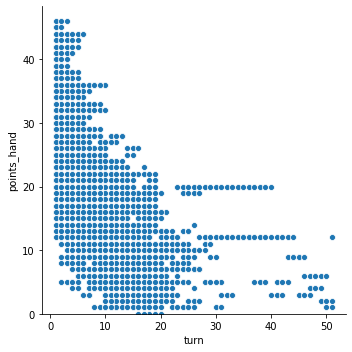

In [6]:
ax = sns.relplot(x='turn', y='points_hand', data=by_player)
_ = ax.set(ylim=(0, None))

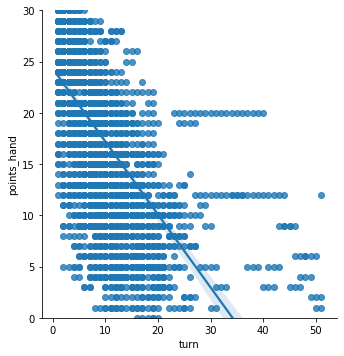

In [7]:
ax = sns.lmplot(x='turn', y='points_hand', data=by_player)
_ = ax.set(ylim=(0, 30))

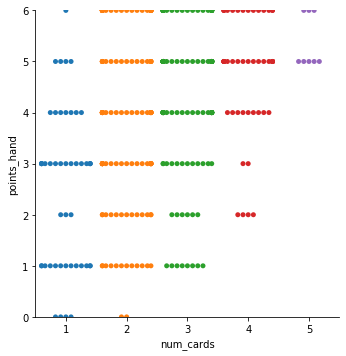

In [8]:
ax = sns.catplot(kind='swarm', x='num_cards', y='points_hand', data=by_player)
_ = ax.set(ylim=(0, 6))

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
games = pd.Series(by_player['game'].unique())
train_games = set(games.sample(round(len(games) * 0.75), random_state=123))
test_games = set(games) - train_games
print(f'Sampled {len(train_games)} games for training, {len(test_games)} games for testing')

Sampled 52 games for training, 18 games for testing


In [11]:
features = by_player.copy().drop(columns=['player'])
features_train = features[features['game'].isin(train_games)].reset_index(drop=True)
features_test = features[features['game'].isin(test_games)].reset_index(drop=True)

feature_names = ['turn', 'num_cards']
target_name = 'points_hand'

X_train = features_train[feature_names]
X_test  = features_test[feature_names]
y_train = features_train[target_name].values.reshape(-1, 1) # for scaler
y_test  = features_test[target_name].values

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('predictor', LinearRegression())])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train).reshape(-1)

pipeline.fit(X_train, y_train_scaled)

pred_scaled = pipeline.predict(X_test)
pred = y_scaler.inverse_transform(pred_scaled)

print(f'RMSE linear regression: {mean_squared_error(y_test, pred, squared=False):.4f}')
print(f'Always predicting mean: {mean_squared_error(y_test, np.zeros(len(y_test)) + np.mean(y_test), squared=False):.4f}')

RMSE linear regression: 6.2620
Always predicting mean: 9.0788


In [12]:
pd.DataFrame([
    {'feature': feat, 'mean': mean, 'var': var, 'weight': weight}
    for feat, mean, var, weight 
    in zip(feature_names, pipeline['scaler'].mean_, pipeline['scaler'].var_, pipeline['predictor'].coef_)
])

,feature,mean,var,weight
0,turn,10.404245,70.365136,-0.283222
1,num_cards,3.802931,1.382083,0.512244


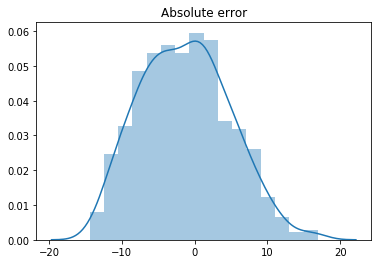

In [13]:
error = y_test - pred
ax = sns.distplot(error)
_ = ax.set_title('Absolute error')

In [14]:
n_samples = 5
sorted_by_error_size = np.argsort(error)

ind = np.hstack([sorted_by_error_size[:n_samples], sorted_by_error_size[-n_samples:]])
big_error_samples = features_test.loc[ind]
big_error_samples['prediction'] = pred[ind]
big_error_samples['error'] = error[ind]
big_error_samples = big_error_samples.drop(columns=['game', 'game+player'])
big_error_samples

,turn,num_cards,points_hand,prediction,error
591,4,5,10,24.423327,-14.423327
593,5,5,10,24.094425,-14.094425
396,12,5,8,21.792111,-13.792111
387,9,5,9,22.778817,-13.778817
399,13,5,8,21.463209,-13.463209
588,2,5,40,25.081131,14.918869
682,1,5,42,25.410033,16.589967
153,1,5,42,25.410033,16.589967
113,1,5,42,25.410033,16.589967
684,2,5,42,25.081131,16.918869
